In [1136]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [1138]:
# pip install --upgrade xgboost


In [1140]:
file_path = r"C:/Users/jugal/OneDrive/Documents/Ironhack_project/Project_ML/heart.csv"
df = pd.read_csv(file_path)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [1142]:
df.shape

(918, 12)

In [1144]:
df.dtypes # Checking the dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [1146]:
df.isna().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [1148]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
913    False
914    False
915    False
916    False
917    False
Length: 918, dtype: bool

In [1150]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [1152]:
df['ChestPainType'].value_counts()

# Will be converted to the numerical values with one-hot coding
# Chest pain types will be categorized as 
# Value 0: typical angina
# Value 1: atypical angina
# Value 2: non-anginal pain
# Value 3: asympotmatic
# Based on the serach results of the Cleveland heart disease (Reference: https://pmc.ncbi.nlm.nih.gov/articles/PMC10378171/)



ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [1154]:
df['RestingECG'].value_counts()

# Will be converted to the numerical values with one-ot coding
# Chest pain types will be categorized as 
# Normal: 552
# LVH (Left Ventricular Hypertroply): 188
# ST: 178
# (Reference: https://pmc.ncbi.nlm.nih.gov/articles/PMC3975313/)




RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [1156]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [1158]:
# Since we can only accept numeric values, we have to turn the categorical variables into numeric
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope']
df_dummy = pd.get_dummies(df[categorical_cols], drop_first=False, dtype=int)
df_dummy


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0,1,0,0,0,1,0,1,0,1,0,0,1,0
914,0,1,1,0,0,0,0,1,0,1,0,0,1,0
915,0,1,1,0,0,0,0,1,0,0,1,0,1,0
916,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [1160]:
df.shape[0]

918

In [1162]:
df_dummy.shape[0]

918

In [1164]:
df.shape[0] == df_dummy.shape[0]

True

In [1166]:
# Joining the data
transformed_df = pd.merge(
    df,
    df_dummy,
    left_index=True,
    right_index=True
 )

In [1168]:
transformed_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,M,ATA,140,289,0,Normal,172,N,0.0,...,0,0,0,1,0,1,0,0,0,1
1,49,F,NAP,160,180,0,Normal,156,N,1.0,...,1,0,0,1,0,1,0,0,1,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,...,0,0,0,0,1,1,0,0,0,1
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,...,0,0,0,1,0,0,1,0,1,0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,...,1,0,0,1,0,1,0,0,0,1


In [1170]:
# Dropping the column that we transformed to numerical
transformed_df.drop(columns = categorical_cols, inplace = True)

In [1172]:
transformed_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [1174]:
# Performing Train Test Split
X_train, X_test, y_train, y_test = train_test_split(transformed_df.drop(columns=['HeartDisease']), transformed_df['HeartDisease'], test_size = 0.2, random_state = 42)

In [1176]:
X_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
795,42,120,240,1,194,0.8,0,1,0,0,1,0,0,1,0,1,0,1,0,0
25,36,130,209,0,178,0.0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
84,56,150,213,1,125,1.0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
10,37,130,211,0,142,0.0,1,0,0,0,1,0,0,1,0,1,0,0,0,1
344,51,120,0,1,104,0.0,0,1,1,0,0,0,0,1,0,1,0,0,1,0


In [1178]:
y_train.head()

795    0
25     0
84     1
10     0
344    1
Name: HeartDisease, dtype: int64

In [1180]:
X_test.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
668,63,140,195,0,179,0.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
30,53,145,518,0,130,0.0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
377,65,160,0,1,122,1.2,0,1,1,0,0,0,0,0,1,1,0,0,1,0
535,56,130,0,0,122,1.0,0,1,1,0,0,0,1,0,0,0,1,0,1,0
807,54,108,309,0,156,0.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1


In [1182]:
y_test.head()

668    0
30     1
377    1
535    1
807    0
Name: HeartDisease, dtype: int64

In [1184]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)  # Transform test data

In [1186]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler.feature_names_in_)
X_train_scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.245067,-0.708985,0.372803,1.842609,2.284353,-0.097061,-0.540605,0.540605,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,0.838461,-0.838461,3.780432,-1.03325,-0.847921
1,-1.886236,-0.166285,0.086146,-0.542709,1.652241,-0.836286,-0.540605,0.540605,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,0.838461,-0.838461,-0.264520,-1.03325,1.179356
2,0.250993,0.919115,0.123134,1.842609,-0.441628,0.087745,-0.540605,0.540605,0.911276,-0.483336,-0.532181,-0.213504,-0.504679,0.808179,-0.487621,-1.192662,1.192662,-0.264520,0.96782,-0.847921
3,-1.779375,-0.166285,0.104640,-0.542709,0.229991,-0.836286,1.849780,-1.849780,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,0.838461,-0.838461,-0.264520,-1.03325,1.179356
4,-0.283314,-0.708985,-1.846478,1.842609,-1.271274,-0.836286,-0.540605,0.540605,0.911276,-0.483336,-0.532181,-0.213504,-0.504679,0.808179,-0.487621,0.838461,-0.838461,-0.264520,0.96782,-0.847921


In [1188]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.dtypes

Age                  float64
RestingBP            float64
Cholesterol          float64
FastingBS            float64
MaxHR                float64
Oldpeak              float64
Sex_F                float64
Sex_M                float64
ChestPainType_ASY    float64
ChestPainType_ATA    float64
ChestPainType_NAP    float64
ChestPainType_TA     float64
RestingECG_LVH       float64
RestingECG_Normal    float64
RestingECG_ST        float64
ExerciseAngina_N     float64
ExerciseAngina_Y     float64
ST_Slope_Down        float64
ST_Slope_Flat        float64
ST_Slope_Up          float64
dtype: object

Based on the above plot, we can say that we're deadling with the imbalanced data

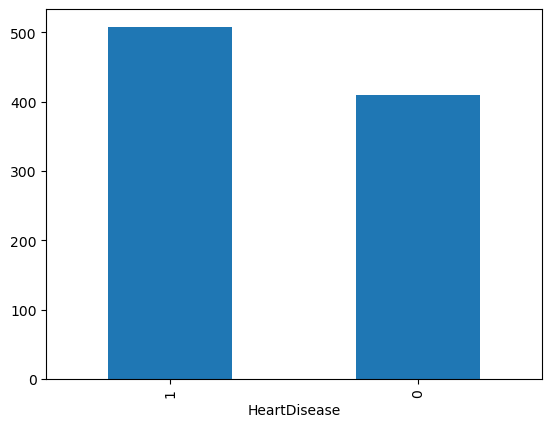

In [1191]:
# Checking Data distribution 
number_of_heartdisease = transformed_df['HeartDisease'].value_counts()
number_of_heartdisease.plot(kind='bar')
plt.show()

In [1193]:
# Define a function to evaluate the model
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a classification model and prints performance metrics.

    Args:
        model: Trained classification model.
        X_test: Scaled test features.
        y_test: Test labels.
        model_name: Name of the model for printing purposes.
    """
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    specificity = TN / (TN + FP)
    accuracy = accuracy_score(y_test, pred)
    auc_score = roc_auc_score(y_test, pred)

    print(f"\n{model_name} Metrics:")
    print("Confusion Matrix:\n", cm)
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")
    print("Classification Report:\n", classification_report(y_test, pred))

Logistic Regression

In [1196]:
# Training with a logisitic regression
log_reg = LogisticRegression()

In [1198]:
log_reg.fit(X_train_scaled, y_train) # Training the model

LogisticRegression()

In [1200]:
# Evaluating the model
evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")


Logistic Regression Metrics:
Confusion Matrix:
 [[67 10]
 [17 90]]
TP: 90, TN: 67, FP: 10, FN: 17
Precision: 0.9000, Recall: 0.8411, Specificity: 0.8701, Accuracy: 0.8533, AUC: 0.8556
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



## Random Forest

In [1203]:
rf = RandomForestClassifier(n_estimators= 100, max_depth = 20, random_state= 42)

In [1205]:
# Training a model
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [1207]:
# Evaluate Random Forest
evaluate_model(rf, X_test_scaled, y_test, "Random Forest")


Random Forest Metrics:
Confusion Matrix:
 [[67 10]
 [12 95]]
TP: 95, TN: 67, FP: 10, FN: 12
Precision: 0.9048, Recall: 0.8879, Specificity: 0.8701, Accuracy: 0.8804, AUC: 0.8790
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



### Gradient Boosting

In [1210]:
gb_cls = GradientBoostingClassifier(n_estimators=100, max_depth=20, random_state=42)

In [1212]:
# Training the model
gb_cls.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=20, random_state=42)

In [1214]:
# Evaluate Gradient Boosting
evaluate_model(gb_cls, X_test_scaled, y_test, "Gradient Boosting")


Gradient Boosting Metrics:
Confusion Matrix:
 [[64 13]
 [22 85]]
TP: 85, TN: 64, FP: 13, FN: 22
Precision: 0.8673, Recall: 0.7944, Specificity: 0.8312, Accuracy: 0.8098, AUC: 0.8128
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.79        77
           1       0.87      0.79      0.83       107

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.81      0.81       184



# XGBoost: Used for handling imbalanced classification tasks, offering several strategies to improve the model performance

In [1217]:
# Calculating scale_pos_weight ( it adjusts the balance between +ve and -ve classes by assigning more weight to the minority class
# pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

In [1219]:
# Initializing XGBClassifier with the scale_pos_weight

xgb = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight = 1
)

In [1221]:
# Fiting the model
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [1223]:
# Evaluate XGBoost
evaluate_model(xgb, X_test_scaled, y_test, "XGBoost")


XGBoost Metrics:
Confusion Matrix:
 [[67 10]
 [13 94]]
TP: 94, TN: 67, FP: 10, FN: 13
Precision: 0.9038, Recall: 0.8785, Specificity: 0.8701, Accuracy: 0.8750, AUC: 0.8743
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



# Hypertuning

## Grid Search

In [1227]:
# Defining the hyperparameters to fine tune

grid = {"n_estimators": [50, 100],
         "learning_rate":[0.01],
        "scale_pos_weight":[1]}

In [1229]:
# Initializing the XGBClassifier

xgb_clf = XGBClassifier(objective='binary:logistic', random_state = 42)

In [1231]:
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=grid, scoring='f1', cv=5)  # Define grid search

In [1233]:
# Fitting to the model
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01], 'n_estimators': [50, 100],
                         'scale_pos_weight': [1]},
             scoring='f1')

In [1235]:
# Runing grid search
best_params = model.best_params_
# Retrieving the best model with the best parameters when accessing best_estimator_ attribute
best_model = model.best_estimator_

print("\nXGBoost Grid Search Best Parameters:", best_params)


XGBoost Grid Search Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 2}


In [1237]:
# Evaluate best XGBoost model
evaluate_model(best_model, X_test_scaled, y_test, "Best XGBoost (Grid Search)")


Best XGBoost (Grid Search) Metrics:
Confusion Matrix:
 [[61 16]
 [10 97]]
TP: 97, TN: 61, FP: 16, FN: 10
Precision: 0.8584, Recall: 0.9065, Specificity: 0.7922, Accuracy: 0.8587, AUC: 0.8494
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82        77
           1       0.86      0.91      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



## Random Search

In [1240]:
# Defining hyerparameter
random = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'min_child_weight': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.8]
}

In [1242]:
# Initializing XGBClassifier with default parameters except those being tuned
xgb_clf = XGBClassifier(objective='binary:logistic', random_state = 42)

In [1244]:
# Runing random search with the cross-validation (5 folds here)
random_search = RandomizedSearchCV(estimator = xgb_clf,
                                   param_distributions=random,
                                   cv=5,
                                   scoring='f1_macro',
                                   n_iter=10,
                                  n_jobs = -1,
                                  random_state = 41)
try:
    random_search.fit(X_train_scaled, y_train)
except (ValueError, TypeError) as e:
    print(f"An error occurred during RandomizedSearchCV: {e}")

C:\Users\jugal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [1245]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_

In [1246]:
print("\nXGBoost Randomized Search Best Parameters:", best_params)



XGBoost Randomized Search Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [1247]:
# Evaluate best XGBoost model
evaluate_model(best_model, X_test_scaled, y_test, "Best XGBoost (Randomized Search)")


Best XGBoost (Randomized Search) Metrics:
Confusion Matrix:
 [[67 10]
 [13 94]]
TP: 94, TN: 67, FP: 10, FN: 13
Precision: 0.9038, Recall: 0.8785, Specificity: 0.8701, Accuracy: 0.8750, AUC: 0.8743
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



## Logistic Regression

In [1253]:
# Define hyperparameter grid
param_grid_lr = [
    {'penalty': ['l1'], 'C': [1.0, 0.1, 0.01, 0.001], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'C': [1.0, 0.1, 0.01, 0.001], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
    {'penalty': ['elasticnet'], 'C': [1.0, 0.1, 0.01], 'solver': ['saga'], 'l1_ratio': [0.2, 0.5, 0.8]}  # Elastic-Net
]


In [1255]:
# Initialize LogisticRegression model
log_model = LogisticRegression(max_iter=10000, random_state = 42)

In [1257]:
# Perform grid search
grid_search_lr = GridSearchCV(estimator=log_model, param_grid = param_grid_lr, cv=5, scoring='f1')

In [1259]:
# Fit the model
grid_search_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid=[{'C': [1.0, 0.1, 0.01, 0.001], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [1.0, 0.1, 0.01, 0.001], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear',
                                     'saga']},
                         {'C': [1.0, 0.1, 0.01], 'l1_ratio': [0.2, 0.5, 0.8],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='f1')

In [1261]:
# Print best parameters and score
best_params_lr = grid_search_lr.best_params_

In [1263]:
# Evaluate best Logistic Regression model
best_lr_model = grid_search_lr.best_estimator_
print("\nBest Logistic Regression Parameters:", best_params_lr)
evaluate_model(best_lr_model, X_test_scaled, y_test, "Best Logistic Regression (Grid Search)")


Best Logistic Regression Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}

Best Logistic Regression (Grid Search) Metrics:
Confusion Matrix:
 [[67 10]
 [17 90]]
TP: 90, TN: 67, FP: 10, FN: 17
Precision: 0.9000, Recall: 0.8411, Specificity: 0.8701, Accuracy: 0.8533, AUC: 0.8556
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



## RandomSearch

In [1266]:
# Define hyperparameter space
param_space = {
    'C': loguniform(1e-5, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

In [1268]:
# Initialize LogisticRegression model
log_model = LogisticRegression(max_iter=10000, random_state = 42)

In [1270]:
# Perform random search
random_search = RandomizedSearchCV(
    estimator=log_model,
    param_distributions=param_space,
    n_iter=50,  # Number of random combinations to try
    cv=5,
    n_jobs=-1,  # Use all available CPU cores
    random_state=1,  #For reproducibility
    scoring='f1'
)

In [1272]:
# Fit the model
random_search.fit(X_train_scaled, y_train)

C:\Users\jugal\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
115 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jugal\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jugal\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jugal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver =

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000,
                                                random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D1722292B0>,
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=1, scoring='f1')

In [1274]:
# Get best parameters and score
best_params = random_search.best_params_
print("\nLogistic Regression Randomized Search Best Parameters:", best_params)


Logistic Regression Randomized Search Best Parameters: {'C': 0.019700881267989263, 'penalty': 'l2', 'solver': 'newton-cg'}


In [1049]:
# Evaluate best Logistic Regression model
best_model = random_search.best_estimator_
evaluate_model(best_model, X_test_scaled, y_test, "Best Logistic Regression (Randomized Search)")


Best Logistic Regression (Randomized Search) Metrics:
Confusion Matrix:
 [[ 82  18]
 [ 15 115]]
TP: 115, TN: 82, FP: 18, FN: 15
Precision: 0.8647, Recall: 0.8846, Specificity: 0.8200, Accuracy: 0.8565, AUC: 0.8523
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       100
           1       0.86      0.88      0.87       130

    accuracy                           0.86       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



### Among the above model, RandomForest perfroms well. Hyperprameter Tuning will be applied to get more improved result

### Hyperparameter tuning of Random Froest

In [1278]:
# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [200, 300, 400, 500],  
    'max_depth': [8, 10, 12, 15], 
    'min_samples_split': [2, 4, 6],  
    'min_samples_leaf': [1, 2, 3],  
    'criterion': ['gini', 'entropy'] 
}

In [1284]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [1286]:
# Perform grid search
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='f1')

In [1288]:
# Fit the grid search to your data
rf_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 10, 12, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [200, 300, 400, 500]},
             scoring='f1')

In [1290]:
# Use the best model for predictions
best_params_rf = rf_grid_search.best_params_ # Finding the best hyperparameter
best_model_rf = rf_grid_search.best_estimator_ # Finding the best model

print("\nBest Random Forest Parameters:", best_params_rf) #Printing out the best parameter


Best Random Forest Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [1292]:
# Evaluate best Random Forest model
evaluate_model(best_model_rf, X_test_scaled, y_test, "Best Random Forest (Grid Search)")


Best Random Forest (Grid Search) Metrics:
Confusion Matrix:
 [[67 10]
 [12 95]]
TP: 95, TN: 67, FP: 10, FN: 12
Precision: 0.9048, Recall: 0.8879, Specificity: 0.8701, Accuracy: 0.8804, AUC: 0.8790
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



### RandomForest - random search

In [1295]:
# Defining the hyperarameter
param_space = {
    'n_estimators': np.arange(100, 1000, step=100),
    'max_depth': [None] + list(range(5, 20)),
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'min_samples_split': np.arange(2, 10, step=2),
    'min_samples_leaf': np.arange(1, 5),
    'criterion': ['gini', 'entropy']
}


In [1297]:
# Initializing the moel
rf_model  = RandomForestClassifier(random_state = 42)


In [1299]:
# Defining n_jobs
n_jobs = -1
# Performing random search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_space,
    n_iter=50,
    cv=5,
    n_jobs= n_jobs,
    random_state=42, 
    error_score='raise' # Set to raise for debugging
)


In [1301]:
# Fitting the random serach to our dta
try:
    random_search.fit(X_train_scaled, y_train)
except Exceptino as e:
    print(f'An error occurred {e}')
    

In [1302]:
best_params = random_search.best_params_
rf_best_model = random_search.best_estimator_
print("\nRandom Forest Randomized Search Best Parameters:", best_params)


Random Forest Randomized Search Best Parameters: {'n_estimators': 800, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 7, 'criterion': 'entropy'}


In [1303]:
# Evaluate best Random Forest model
evaluate_model(rf_best_model, X_test_scaled, y_test, "Best Random Forest (Randomized Search)")


Best Random Forest (Randomized Search) Metrics:
Confusion Matrix:
 [[68  9]
 [14 93]]
TP: 93, TN: 68, FP: 9, FN: 14
Precision: 0.9118, Recall: 0.8692, Specificity: 0.8831, Accuracy: 0.8750, AUC: 0.8761
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86        77
           1       0.91      0.87      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



# Pickle

In [650]:
filename = 'linear-regression.pkl'
pickle.dump(log_reg, open(filename, 'wb'))

filename = 'xgb_clf.pkl'
pickle.dump(xgb_clf, open(filename, 'wb'))

filename = 'rf.pkl'
pickle.dump(rf, open(filename, 'wb'))